## The Problem

Bellhops is a startup moving company that contracts movers and drivers to provide a high-quality, on-demand moving experience to consumers.  One of the company's logistical challenges is figuring out how long a move should be scheduled for. Roughly 30% of moves go significantly over the reserved time. In addition to frustrating customers, runovers can cause a back-up throughout the rest of the day, sometimes causing cancellations for later moves. In general, we try to schedule moves so that if they are completed in under 3 hours. If we could better predict whether or not a move was going to exceed the three-hour mark, Bellhops would be able to improve scheduling and thereby improve the customer experience.


## Data

The data come from Bellhops’ internal data warehouse. For each move the company performs, it collects the following features:

Order Number - the internal id for the move

Market - the city in which the move took place

FS - whether or not the move was a full service move, i.e. included a truck

Move Type - the type of move

Move Length Hours - the time between reservation start and the last clock out

Booking Platform - whether the move was booked online or over the phone

Executed Man Hours - the number of man hours it took to complete the move

Booked Man Hours - the number of man hour that were booked

Order Total Spots - the number of movers that worked on the order

House - whether or not the property type was a house

Residence - whether or not the property was a residence

Rooms - the number of rooms on the property

Coupon Amount - the value of the customer's coupon, if present

GRPN - whether or not the move was from Groupon

Num Effort Hops - the number of hops that had previousely received poor effort ratings from customers

Some Inventory - whether or not he customer provided us with any inventory during the bookig process

"Beds" through "Boxes" - the number of the named items the customer reported.

Reservation Start - the datetime at which the reservation was scheduled to start

Booked At - the date time at which the order was booked

Dense - whether or not the order occurred in a market with more that 10k people per sq. mile

Flights of Stairs - the total number of flights of stairs for all properties on the move

Large/Medium/Small Items - the number of "large"/"medium"/"small" items reported during the booking process

Stops - the number of locations on the move

Elevators - the number of elevators reported during the booking porcess

Additional Instructions - whether or not the customer reported additional instructions during the booking process

Columns begining with "Calculator_" - columns from a rarely used pre-move survey intended to collect additional inventory

NPS - net promoter score

Num Bad Star Hops - the number of hops on the job with previous low overall reviews

Avg Prev Late Rate - the average of the movers' rates of being late on previous moves

Sum Prev Late Rate - the sum of the movers' rates of being late on previous moves

Max Late Clock In Hours - the latest any mover was to the move in hours

Sum Late Clock In Hours - the total number of man hours that movers where late the move

City Pop - the population in the market

Pop Density - the population density of a market

## Cleaning

#### Setting Up
First, I imported pandas so I could work with this data as a DataFrame and numpy for feature engineering. I read the csv into a pandas DataFrame, with column ‘order_id’ as the index. 

#### Removing Extraneous Columns and Rows
This whole dataset incorporates a few months of data for customers that booked both on the web and over the phone. I removed the columns beginning with ‘calculator_’ because they are the result of a pre-move survey Bellhops only gave to some customers who booked over the phone over the past couple of weeks. The survey asks questions that would seem helpful in the move length estimation process like “is there a basement at the first location?” “is there an elevator at the second location?” etc. However, because about 98% of the responses were null, they were only from recent phone orders and not randomly distributed throughout the dataset, and there was no logical way to replace the values, I decided to drop the 10 columns. (Hopefully in a future analysis those can be incorporated.)

Furthermore, I dropped about 300 rows out of almost 9,000 where the ‘move_length_hours’ column was null or less than 0. (There is clearly an issue with the data if it says the start time was after the end time.) As the independent variable is based on this column, it made no sense to replace values.

#### Feature Engineering
With this project, I am trying to predict whether or not a move will run over 4 hours. Bellhops never intentionally books a move over four hours as it can cause a back-up throughout the rest of the day. I generated a column to represent the independent variable called ‘over’ that gives a '1' if the move length was over 4 hours and a '0' if not.

I transformed the ‘property_type_name’ column, which describes whether a property is a house, apartment, storage facility, etc. from an object type into a categorical variable and transformed the ‘booked_at’ and ‘reservation_start’ columns into datetimes.

From the ‘reservation_start’ column, I added columns that represent the hour of day the move began, whether or not that was in the morning, the day of week the move began, and whether or not that was a weekend day.

Finally, I wrote the data to a csv, ready for exploratory data analysis. To see the code for this process, please check out [this notebook](https://github.com/maryscottsanders/spring/blob/master/Cleaning%20Move%20Length%20Estimation%20Data.ipynb).



## Exploratory Data Analysis

In [2]:
#Load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
#Read csv into a pandas dataframe.
csv = 'move_est.csv'
df = pd.read_csv(csv, index_col = 'order_id')
df.describe()

,fs,move_length_hours,executed_man_hours,booked_man_hours,order_total_spots,house,residence,rooms,coupon_amount,min_billable_man_hours,...,mkt_nashvilletn,mkt_phoenixaz,mkt_pittsburghpa,mkt_raleighdurhamchapelhillnc,mkt_saintlouismo,mkt_washingtondcdc,mt_atob,mt_gopher,mt_inhouselabor,mt_loading
count,6960.000000,6960.000000,6960.000000,6960.000000,6960.000000,6960.000000,6960.000000,6960.000000,6960.000000,6960.000000,...,6960.000000,6960.000000,6960.000000,6960.000000,6960.000000,6960.000000,6960.000000,6960.000000,6960.000000,6960.000000
mean,0.510776,2.558733,6.204562,5.996121,2.203736,0.367960,0.917960,1.523563,35.174872,3.021552,...,0.093966,0.002443,0.046695,0.099569,0.035632,0.032615,0.083333,0.510776,0.122270,0.139080
std,0.499920,1.738273,5.017244,3.916913,0.531668,0.482285,0.274446,0.937487,102.845475,0.999840,...,0.291802,0.049365,0.211001,0.299446,0.185385,0.177639,0.276405,0.499920,0.327621,0.346055
min,0.000000,0.006944,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.274931,3.000000,4.000000,2.000000,0.000000,1.000000,1.000000,0.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,2.236944,5.000000,6.000000,2.000000,0.000000,1.000000,1.000000,0.000000,4.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,1.000000,3.416667,7.500000,8.000000,2.000000,1.000000,1.000000,2.000000,10.000000,4.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,1.000000,15.300000,79.750000,56.000000,7.000000,1.000000,1.000000,5.000000,3450.500000,4.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


33 % of moves run over 3 hours.


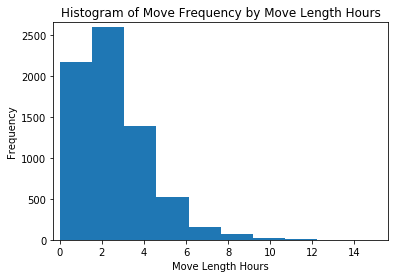

In [4]:
#Percent of moves over 3hr threshold
perc_over = round(np.mean(df.over)*100)
print(perc_over,"% of moves run over 3 hours.")

#Histogram of frequency of move lengths
plt.hist(df.move_length_hours)
plt.title('Histogram of Move Frequency by Move Length Hours')
plt.xlabel('Move Length Hours')
plt.ylabel('Frequency')
plt.margins(.02)
plt.show()

In [5]:
#Bellhops knows that full service moves tend to be longer than labor only moves, but by how much?
df['move_length_hours'].groupby(df['fs']).describe()

,count,mean,std,min,25%,50%,75%,max
fs,,,,,,,,
0,3405.0,1.638159,1.252532,0.006944,0.772222,1.333333,2.166667,14.583333
1,3555.0,3.440465,1.680562,0.236111,2.250000,3.111111,4.216667,15.300000


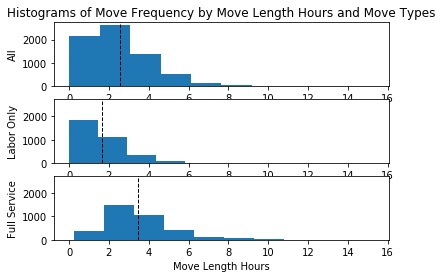

In [6]:
#What does move length distributions look like by move type?
ax1 = plt.subplot(3,1,1)
plt.hist(df.move_length_hours)
plt.axvline(df.move_length_hours.mean(), color='k', linestyle='dashed', linewidth=1)
plt.title('Histograms of Move Frequency by Move Length Hours and Move Types')
plt.ylabel('All')

plt.subplot(3,1,2,sharex=ax1,sharey=ax1)
plt.hist(df.move_length_hours[df.fs==0])
plt.axvline(df.move_length_hours[df.fs==0].mean(), color='k', linestyle='dashed', linewidth=1)
plt.ylabel('Labor Only')

plt.subplot(3,1,3,sharex=ax1,sharey=ax1)
plt.hist(df.move_length_hours[df.fs==1])
plt.axvline(df.move_length_hours[df.fs==1].mean(), color='k', linestyle='dashed', linewidth=1)
plt.ylabel('Full Service')
plt.xlabel('Move Length Hours')

plt.show()

In [7]:
#How much more likely are full service moves to go over the threshold than labor only moves?
df['over'].groupby(df['fs']).mean()

fs
0    0.117181
1    0.526301
Name: over, dtype: float64

In [8]:
df['executed_man_hours'].groupby(df['move_type']).mean()

move_type
atob            5.595690
gopher          8.348312
inhouselabor    2.873384
loading         4.290289
unloading       3.639911
Name: executed_man_hours, dtype: float64

In [9]:
df['over'].groupby(df['move_type']).mean()

move_type
atob            0.296552
gopher          0.526301
inhouselabor    0.032902
loading         0.130165
unloading       0.072565
Name: over, dtype: float64

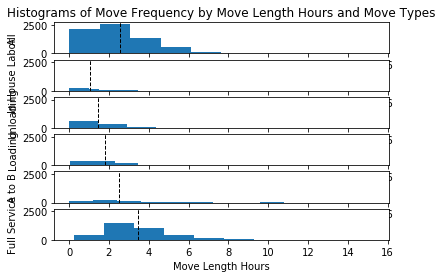

In [10]:
#What does move length distributions look like by move type?
ax1 = plt.subplot(6,1,1)
plt.hist(df.move_length_hours)
plt.axvline(df.move_length_hours.mean(), color='k', linestyle='dashed', linewidth=1)
plt.title('Histograms of Move Frequency by Move Length Hours and Move Types')
plt.ylabel('All')

plt.subplot(6,1,2,sharex=ax1,sharey=ax1)
plt.hist(df.move_length_hours[df.move_type=='inhouselabor'])
plt.axvline(df.move_length_hours[df.move_type=='inhouselabor'].mean(), color='k', linestyle='dashed', linewidth=1)
plt.ylabel('In House Labor')

plt.subplot(6,1,3,sharex=ax1,sharey=ax1)
plt.hist(df.move_length_hours[df.move_type=='unloading'])
plt.axvline(df.move_length_hours[df.move_type=='unloading'].mean(), color='k', linestyle='dashed', linewidth=1)
plt.ylabel('Unloading')

plt.subplot(6,1,4,sharex=ax1,sharey=ax1)
plt.hist(df.move_length_hours[df.move_type=='loading'])
plt.axvline(df.move_length_hours[df.move_type=='loading'].mean(), color='k', linestyle='dashed', linewidth=1)
plt.ylabel('Loading')

plt.subplot(6,1,5,sharex=ax1,sharey=ax1)
plt.hist(df.move_length_hours[df.move_type=='atob'])
plt.axvline(df.move_length_hours[df.move_type=='atob'].mean(), color='k', linestyle='dashed', linewidth=1)
plt.ylabel('A to B')

plt.subplot(6,1,6,sharex=ax1,sharey=ax1)
plt.hist(df.move_length_hours[df.move_type=='gopher'])
plt.axvline(df.move_length_hours[df.move_type=='gopher'].mean(), color='k', linestyle='dashed', linewidth=1)
plt.ylabel('Full Service')

plt.xlabel('Move Length Hours')

plt.show()

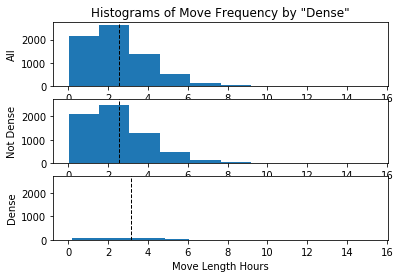

In [11]:
#Bellhops thinks that moves take longer in the most densely populated cities
ax1 = plt.subplot(3,1,1)
plt.hist(df.move_length_hours)
plt.axvline(df.move_length_hours.mean(), color='k', linestyle='dashed', linewidth=1)
plt.title('Histograms of Move Frequency by "Dense"')
plt.ylabel('All')

plt.subplot(3,1,2,sharex=ax1,sharey=ax1)
plt.hist(df.move_length_hours[df.dense==0])
plt.axvline(df.move_length_hours[df.dense==0].mean(), color='k', linestyle='dashed', linewidth=1)
plt.ylabel('Not Dense')

plt.subplot(3,1,3,sharex=ax1,sharey=ax1)
plt.hist(df.move_length_hours[df.dense==1])
plt.axvline(df.move_length_hours[df.dense==1].mean(), color='k', linestyle='dashed', linewidth=1)
plt.ylabel('Dense')

plt.xlabel('Move Length Hours')
plt.show()

There might be something there, but there are so few observations in the "dense" bucket.

In [34]:
#Bellhops has a hunch that there are persitent move length differences amoung markets. Here are mean move lengths by market and move type
ml = pd.crosstab(df.market, df.broad_move_type, values=df.move_length_hours, aggfunc=np.mean)

ml.sort_values('full_service',ascending=False)


broad_move_type,full_service,labor_only
market,,
washingtondcdc,4.316959,1.699580
pittsburghpa,3.926935,1.838543
saintlouismo,3.800980,1.800604
atlantaga,3.772254,1.806691
birminghamal,3.745658,1.760704
kansascitymo,3.557435,1.726419
denverco,3.461667,1.615118
houstontx,3.369601,1.583328
chicagoil,3.362394,1.784832


In [37]:
#Removing pheonix because it is a very new market and is obviousely an outlier.
mla = ml[ml['labor_only']<4]

In [36]:
mla.reset_index(inplace=True)

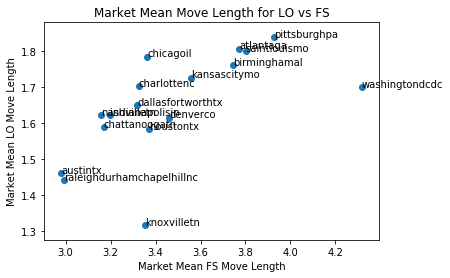

In [15]:
plt.scatter(mla.full_service,mla.labor_only)
plt.title('Market Mean Move Length for LO vs FS')
plt.xlabel('Market Mean FS Move Length')
plt.ylabel('Market Mean LO Move Length')
for i, market in enumerate(mla.market):
    plt.annotate(mla.market[i], (mla.full_service[i],mla.labor_only[i]))
plt.show()

It is interesting to see that move lengths of different move types are correlated for markets. This seems to suggest there are market specific differences that aren't just due to markets having different distributions of move types.

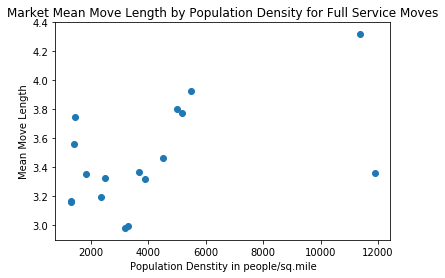

In [16]:
#Are these market specific differences driven by population density?
pop = pd.DataFrame(df['pop_density'].groupby(df['market']).mean())
ml_pop = ml.join(pop)

plt.scatter(ml_pop.pop_density,ml_pop.full_service)
plt.title('Market Mean Move Length by Population Density for Full Service Moves')
plt.xlabel('Population Denstity in people/sq.mile')
plt.ylabel('Mean Move Length')
plt.show()


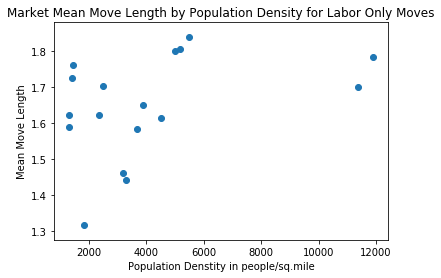

In [17]:
plt.scatter(ml_pop.pop_density,[ml_pop.labor_only])
plt.title('Market Mean Move Length by Population Density for Labor Only Moves')
plt.xlabel('Population Denstity in people/sq.mile')
plt.ylabel('Mean Move Length')
plt.show()


There isn't a plethora of observations, but the labor only scatter plot does suggest a positve correlation between mean move length and population density.

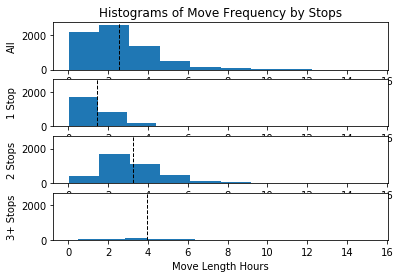

In [18]:
#We think that moves take longer the more stops there are
ax1 = plt.subplot(4,1,1)
plt.hist(df.move_length_hours)
plt.axvline(df.move_length_hours.mean(), color='k', linestyle='dashed', linewidth=1)
plt.title('Histograms of Move Frequency by Stops')
plt.ylabel('All')

plt.subplot(4,1,2,sharex=ax1,sharey=ax1)
plt.hist(df.move_length_hours[df.stops==1])
plt.axvline(df.move_length_hours[df.stops==1].mean(), color='k', linestyle='dashed', linewidth=1)
plt.ylabel('1 Stop')

plt.subplot(4,1,3,sharex=ax1,sharey=ax1)
plt.hist(df.move_length_hours[df.stops==2])
plt.axvline(df.move_length_hours[df.stops==2].mean(), color='k', linestyle='dashed', linewidth=1)
plt.ylabel('2 Stops')

plt.subplot(4,1,4,sharex=ax1,sharey=ax1)
plt.hist(df.move_length_hours[df.stops>=3])
plt.axvline(df.move_length_hours[df.stops>=3].mean(), color='k', linestyle='dashed', linewidth=1)
plt.ylabel('3+ Stops')

plt.xlabel('Move Length Hours')
plt.show()

The top three histograms look very similar to the move type histograms. It is interesting to see this 3+ stop difference, although sample size for that group is small.

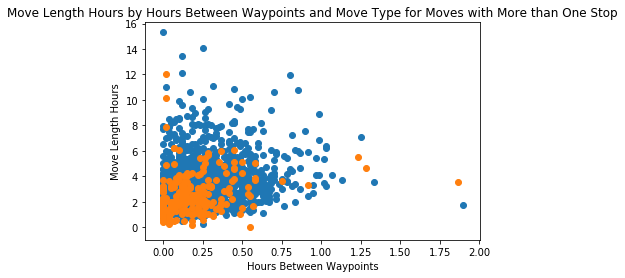

In [19]:
#You would think that drive time between waypoints would directly add to the move length
plt.scatter(df['hours_between_waypoints'][(df['fs']==1) & (df['stops']>1)],df['move_length_hours'][(df['fs']==1) & (df['stops']>1)])
plt.scatter(df['hours_between_waypoints'][(df['fs']==0) & (df['stops']>1)],df['move_length_hours'][(df['fs']==0) & (df['stops']>1)])
plt.title('Move Length Hours by Hours Between Waypoints and Move Type for Moves with More than One Stop')
plt.ylabel('Move Length Hours')
plt.xlabel('Hours Between Waypoints')
plt.show()

The relationship isn't extremely clear here. Variance/noise caused by other factor swamps the impact visually.

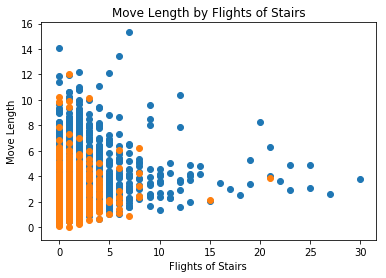

In [20]:
#Scatter for flights of stairs
plt.scatter(df['flights_of_stairs'][(df['fs']==1) & (df['stops']>1)],df['move_length_hours'][(df['fs']==1) & (df['stops']>1)])
plt.scatter(df['flights_of_stairs'][(df['fs']==0) & (df['stops']>1)],df['move_length_hours'][(df['fs']==0) & (df['stops']>1)])
plt.title('Move Length by Flights of Stairs')
plt.xlabel('Flights of Stairs')
plt.ylabel('Move Length')
plt.show()

In [21]:
#Is there a relationship between move length and whether or not the move occured in the morning?
df['move_length_hours'].groupby([df['fs'],df['morning']]).describe()

count      mean       std       min       25%       50%  \
fs morning                                                             
0  0        1587.0  1.392505  0.970185  0.006944  0.671111  1.160278   
   1        1818.0  1.852599  1.420836  0.016667  0.883333  1.568889   
1  0        1572.0  3.126374  1.416030  0.236111  2.118889  2.881389   
   1        1983.0  3.689457  1.826122  0.555000  2.400000  3.300000   

                 75%        max  
fs morning                       
0  0        1.921806   6.584167  
   1        2.416597  14.583333  
1  0        3.889028   9.983333  
   1        4.518056  15.300000

In [22]:
#Is there a relationship between move length and whether or not the move occured over the weekend?
df['move_length_hours'].groupby([df['fs'],df['weekend']]).describe()

count      mean       std       min       25%       50%  \
fs weekend                                                             
0  0        1548.0  1.618086  1.282820  0.016667  0.747917  1.307083   
   1        1857.0  1.654892  1.226808  0.006944  0.816667  1.359444   
1  0        1584.0  3.438731  1.783200  0.236111  2.183333  3.083333   
   1        1971.0  3.441858  1.593751  0.500000  2.301389  3.133333   

                 75%        max  
fs weekend                       
0  0        2.156458  12.074167  
   1        2.166667  14.583333  
1  0        4.251528  15.300000  
   1        4.183333  12.203889

In [23]:
#Add a column for correct booked man hours
#df['correct_booked_man_hours'] = np.ceil(df['executed_man_hours']/2)*2
df['even_base'] = np.where(np.floor(df['executed_man_hours'])%2==0,1,0)
df['small_mins'] = np.where(df['executed_man_hours'] - np.floor(df['executed_man_hours'])<= .5, 1, 0)
df['correct_booked_man_hours'] = np.where((df['even_base']==1) & (df['small_mins'] == 1), np.floor(df['executed_man_hours']/2)*2,np.ceil(df['executed_man_hours']/2)*2 )

In [24]:
#df.property_type_name.unique()
print(df.columns.values)

['messy_market' 'market' 'order_number' 'broad_move_type' 'move_type' 'fs'
 'move_length_hours' 'booking_agent' 'booking_platform'
 'executed_man_hours' 'booked_man_hours' 'order_total_spots'
 'property_size_name' 'property_type_name' 'house' 'residence' 'rooms'
 'coupon_amount' 'min_billable_man_hours' 'damage_cost' 'damage'
 'appeasement' 'appeasement_cost' 'grpn' 'grpn200' 'num_effort_hops'
 'some_inventory' 'beds' 'desks' 'chairs' 'ables' 'dressers'
 'washing_machines' 'couches' 'bookshelves' 'boxes' 'reservation_start'
 'booked_at' 'dense' 'stairs_3_no_el' 'flights_of_stairs' 'large_items'
 'medium_items' 'small_items' 'stops' 'elevators'
 'additional_instructions' 'minutes_between_waypoints'
 'miles_between_waypoints' 'nps_score' 'nps_promoter' 'nps_detractor'
 'num_bad_star_hops' 'avg_prev_late_rate' 'sum_prev_late_rate'
 'max_late_clock_in_hours' 'sum_late_clock_in_hours' 'city_pop'
 'pop_density' 'phone' 'add_hops' 'over' 'hours_between_waypoints'
 'hour_of_day' 'morning' 'day

In [25]:
#Feature engineering
df['second_stop'] = np.where(df['stops'] >=2,1,0)
df['extra_stop'] = np.where(df['stops'] >2,df['stops']-2,0)
df['extra_hop'] = np.where(df['order_total_spots'] >2,df['order_total_spots'] - 2,0)
df['web_extra_hop'] = np.where((df['order_total_spots'] >2) & (df['phone'] == 1),df['order_total_spots'] - 2,0)
df['extra_rooms'] = np.where(df['rooms'] > 1,df['rooms']-1,0)
df['vd'] = np.where(df['pop_density']>5000,1,0)
df['pop_density'] = df['pop_density']/4000
df['coupon'] = np.where(df['coupon_amount'] > 0,1,0)

#Adding interaction columns
df['fs_dense'] = df['fs']*df['dense']
df['fs_rooms'] = df['fs']*df['rooms']
df['dense_apt'] = np.where((df['property_type_name']=='Apartment/Condo') & (df['dense']==1),1,0)

df['second_stop_extra_rooms'] = df['second_stop']*df['extra_rooms']
df['second_stop_dense'] = df['second_stop']*df['dense']
df['second_stop_extra_rooms_dense'] = df['second_stop']*df['extra_rooms']*df['dense']

df['dense_rooms'] = df['vd']*df['rooms']
df['house_rooms'] = df['house']*df['rooms']
df['rooms_stairs'] = df['rooms']*df['flights_of_stairs']
df['rooms_stairs_stops'] = df['rooms']*df['flights_of_stairs']* df['stops']
df['rooms_squared'] = df['rooms']*df['rooms']

#check to see what I didn't include
#try testing a few as quadratic: rooms, num_effort_hops
#flight of stairs*elevator
#dense*apt
#stairs*hop_ratings
#booking an additional hop online means something different than over the phone?
#booking an additional hour online means something different thank over the phone?

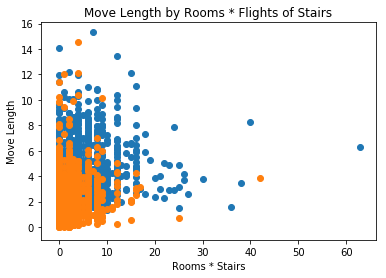

In [26]:
#Scatter for flights of stairs
plt.scatter(df['rooms_stairs'][(df['fs']==1)],df['move_length_hours'][(df['fs']==1)])
plt.scatter(df['rooms_stairs'][(df['fs']==0)],df['move_length_hours'][(df['fs']==0)])
plt.title('Move Length by Rooms * Flights of Stairs')
plt.xlabel('Rooms * Stairs')
plt.ylabel('Move Length')
plt.show()

In [27]:
#Adding dummies for markets, leaving Atlanta out

market_dummies = ['mkt_austintx', 'mkt_birminghamal',
       'mkt_charlottenc', 'mkt_chattanoogatn', 'mkt_chicagoil',
       'mkt_dallasfortworthtx', 'mkt_denverco', 'mkt_houstontx',
       'mkt_indianapolisin', 'mkt_kansascitymo', 'mkt_knoxvilletn',
       'mkt_nashvilletn', 'mkt_phoenixaz', 'mkt_pittsburghpa',
       'mkt_raleighdurhamchapelhillnc', 'mkt_saintlouismo',
       'mkt_washingtondcdc']

#Adding dummies for move_types, leaving unloading out
move_type_dummies = ['mt_atob', 'mt_gopher', 'mt_inhouselabor','mt_loading']

## Inferential Statistics

In [28]:
#Generate correlation matrix and take the absolute value
c = df.corr().abs()

#Take the colum that represent correlations with the independent variable and sort by  largest correlation
d = c.move_length_hours.sort_values(ascending=False)

#Display all items in series
with pd.option_context('display.max_rows', None, 'display.max_columns', 3):
    print(d)

move_length_hours                1.000000
executed_man_hours               0.844994
correct_booked_man_hours         0.843014
over                             0.781958
booked_man_hours                 0.636642
fs_rooms                         0.542807
second_stop                      0.526516
fs                               0.518335
min_billable_man_hours           0.518335
mt_gopher                        0.518335
stops                            0.479784
hours_between_waypoints          0.479107
minutes_between_waypoints        0.479107
second_stop_extra_rooms          0.427019
miles_between_waypoints          0.407927
nps_score                        0.380171
max_late_clock_in_hours          0.367046
nps_detractor                    0.348566
sum_late_clock_in_hours          0.343847
extra_hop                        0.342728
add_hops                         0.342728
order_total_spots                0.337339
nps_promoter                     0.337139
rooms_stairs_stops               0

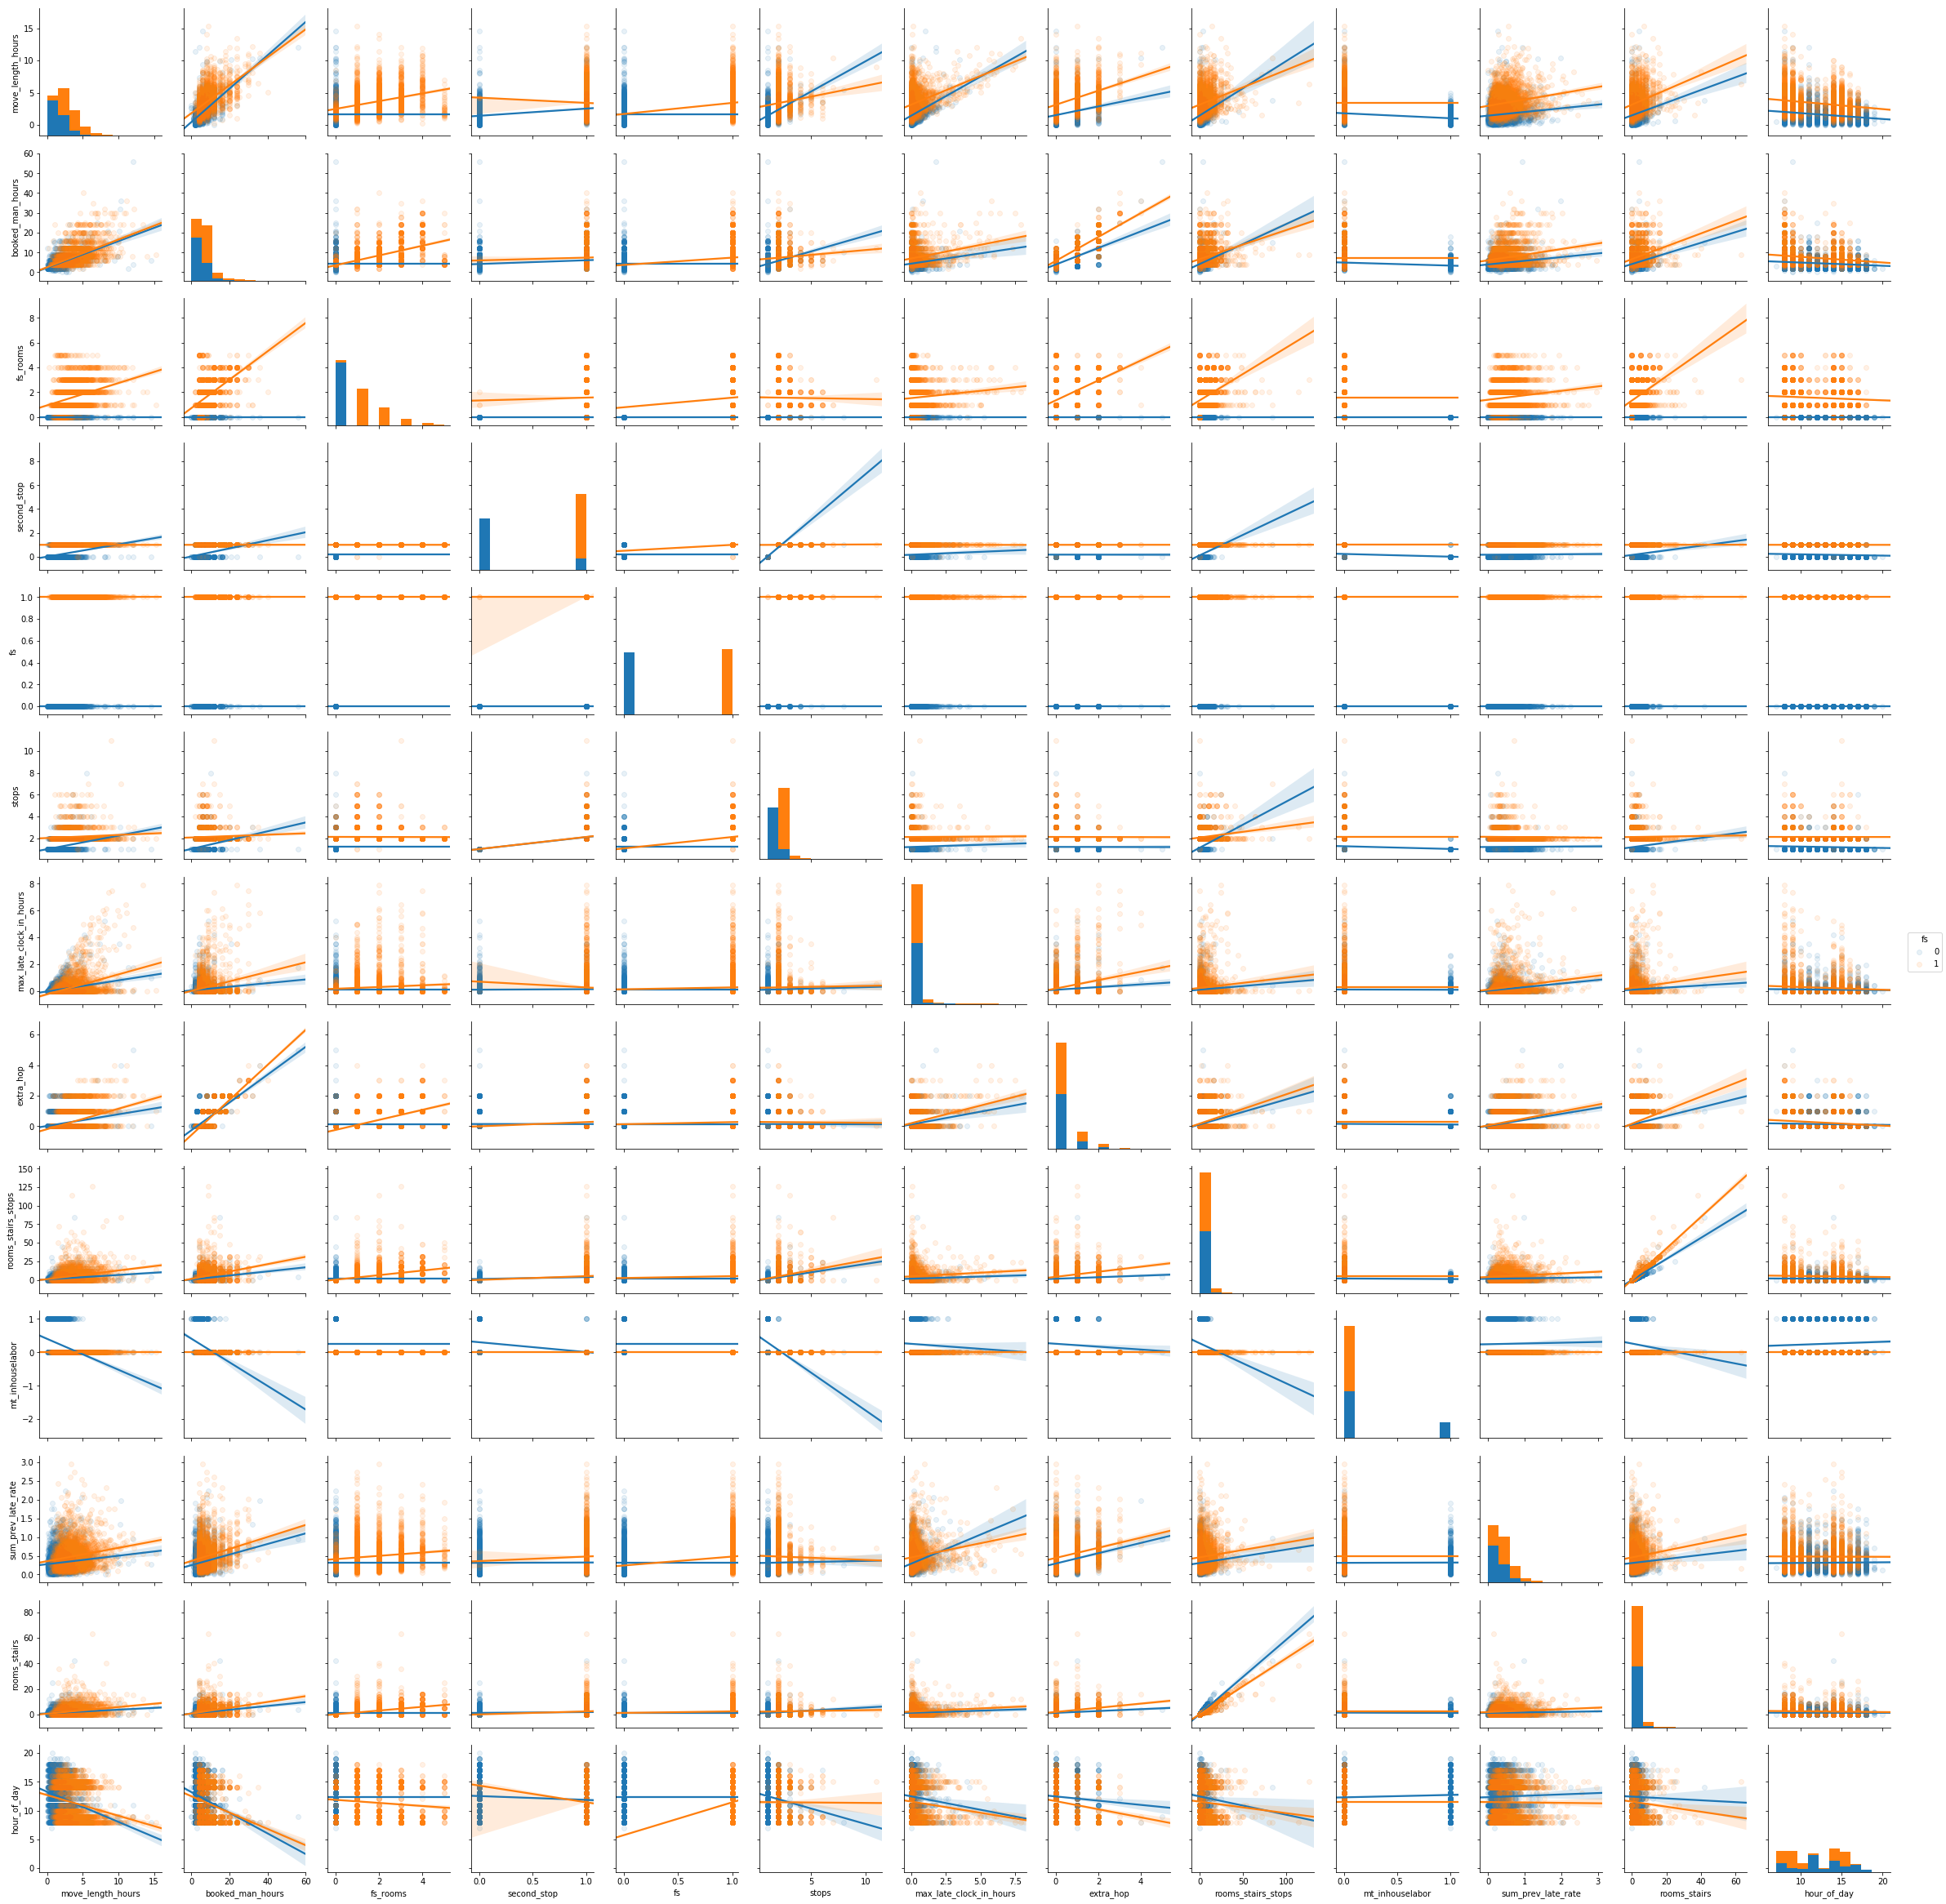

In [29]:
#Select the target variable and features that are most highly correlated with the target variable
#pair_vars = ['move_length_hours', 'booked_man_hours','fs_rooms','second_stop','fs','stops','hours_between_waypoints','max_late_clock_in_hours','extra_hop','rooms_stairs_stops','mt_inhouselabor','bookshelves','sum_prev_late_rate','rooms_stairs','hour_of_day'] 
pair_vars = ['move_length_hours', 'booked_man_hours','fs_rooms','second_stop','fs','stops','max_late_clock_in_hours','extra_hop','rooms_stairs_stops','mt_inhouselabor','sum_prev_late_rate','rooms_stairs','hour_of_day']
sns.pairplot(df, vars= pair_vars, hue='fs',kind="reg", plot_kws={'scatter_kws': {'alpha': 0.1}})


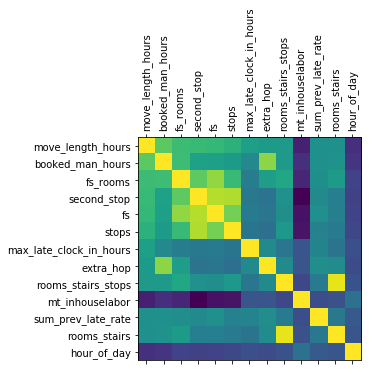

In [30]:
#plotting correlation matrix to easily visualize which of the most highly correlated features are higly correlated with each other.

#Generate and show a correlation matrix
df_corr = df[pair_vars]
plt.matshow(df_corr.corr())
 
#Add x labels
x_pos = np.arange(len(pair_vars))
plt.xticks(x_pos,pair_vars, rotation=90)

#Add y labels
y_pos = np.arange(len(pair_vars))
plt.yticks(y_pos,pair_vars)

#Show
plt.show()

In [31]:
#Below is a regression for move length hours

df_lasso = df[(df.hours_between_waypoints.notnull())]
x_cols = ['fs','booked_man_hours','extra_hop','extra_stop','house','residence','rooms','grpn','avg_prev_late_rate','elevators','hours_between_waypoints','hour_of_day','house_rooms','rooms_stairs','coupon','dense', 'sum_prev_late_rate']+ market_dummies + move_type_dummies 

X = df_lasso[x_cols]
y = df_lasso['move_length_hours']


X = sm.add_constant(X)
est = sm.OLS(y, X).fit()

est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      move_length_hours   R-squared:                       0.601
Model:                            OLS   Adj. R-squared:                  0.598
Method:                 Least Squares   F-statistic:                     184.7
Date:                Fri, 25 May 2018   Prob (F-statistic):               0.00
Time:                        10:58:48   Log-Likelihood:                -6615.0
No. Observations:                4452   AIC:                         1.330e+04
Df Residuals:                    4415   BIC:                         1.354e+04
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                             0.6635      0.124      5.352      0.000       0.420       0.907
fs                                0.4315      0.031     13.878      0.000       0.371       0.492
booked_man_hours                  0.2461      0.008     32.771      0.000       0.231       0.261
extra_hop                        -0.5867      0.051    -11.435      0.000      -0.687      -0.486
extra_stop                        0.1996      0.056      3.588      0.000       0.091       0.309
house                           8.64e-05      0.065      0.001      0.999      -0.128       0.128
residence                         0.0682      0.064      1.059      0.289      -0.058       0.194
rooms                             0.1219      0.029      4.242      0.000       0.066       0.178
grpn                              0.1057      0.071      1.481      0.139      -0.034       0.246
avg_prev_late_rate               -0.7170      0.397     -1.806      0.071      -1.496       0.062
elevators                         0.3848      0.039      9.825      0.000       0.308       0.462
hours_between_waypoints           0.6049      0.136      4.438      0.000       0.338       0.872
hour_of_day                      -0.0313      0.006     -5.638      0.000      -0.042      -0.020
house_rooms                      -0.0051      0.036     -0.142      0.887      -0.076       0.065
rooms_stairs                      0.0270      0.007      3.933      0.000       0.014       0.040
coupon                            0.0889      0.053      1.679      0.093      -0.015       0.193
dense                             0.0391      0.056      0.704      0.481      -0.070       0.148
sum_prev_late_rate                0.2653      0.106      2.501      0.012       0.057       0.473
mkt_austintx                     -0.1957      0.081     -2.431      0.015      -0.354      -0.038
mkt_birminghamal                 -0.0449      0.087     -0.515      0.607      -0.216       0.126
mkt_charlottenc                  -0.1785      0.078     -2.275      0.023      -0.332      -0.025
mkt_chattanoogatn                -0.3470      0.067     -5.162      0.000      -0.479      -0.215
mkt_chicagoil                    -0.0740      0.074     -0.995      0.320      -0.220       0.072
mkt_dallasfortworthtx            -0.1305      0.080     -1.642      0.101      -0.286       0.025
mkt_denverco                     -0.0865      0.090     -0.961      0.336      -0.263       0.090
mkt_houstontx                    -0.2022      0.104     -1.951      0.051      -0.405       0.001
mkt_indianapolisin               -0.2588      0.097     -2.675      0.008      -0.449      -0.069
mkt_kansascitymo                 -0.2491      0.094     -2.639      0.008      -0.434      -0.064
mkt_knoxvilletn                  -0.3349     

In [32]:
import statsmodels.formula.api as smf
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

df_log = df[(df.hours_between_waypoints.notnull())]
x_cols = ['booked_man_hours','extra_hop','extra_stop','house','residence','rooms','grpn','avg_prev_late_rate','elevators','hours_between_waypoints','hour_of_day','house_rooms','rooms_stairs','coupon']+ market_dummies + move_type_dummies

X = df_log[x_cols]
y = df_log['over']

import statsmodels.api as sm
logit_model=sm.Logit(y,X)
result=logit_model.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.349414
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   over   No. Observations:                 4452
Model:                          Logit   Df Residuals:                     4417
Method:                           MLE   Df Model:                           34
Date:                Fri, 25 May 2018   Pseudo R-squ.:                  0.3835
Time:                        10:58:48   Log-Likelihood:                -1555.6
converged:                       True   LL-Null:                       -2523.1
                                        LLR p-value:                     0.000
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
booked_man_hours                  0.3761      0.025     14.880      0.000       0.327       0.426
extra_hop                        -1.0276      0.142     -7.237      0.000      -1.306      -0.749
extra_stop                        0.2169      0.138      1.575      0.115      -0.053       0.487
house                            -0.8284      0.198     -4.188      0.000      -1.216      -0.441
residence                        -0.9475      0.151     -6.283      0.000      -1.243      -0.652
rooms                            -0.1506      0.077     -1.961      0.050      -0.301   -9.21e-05
grpn                              0.5464      0.183      2.980      0.003       0.187       0.906
avg_prev_late_rate               -1.6611      0.707     -2.350      0.019      -3.046      -0.276
elevators                         0.3976      0.096      4.157      0.000       0.210       0.585
hours_between_waypoints           1.6454      0.342      4.805      0.000       0.974       2.317
hour_of_day                      -0.1589      0.013    -12.238      0.000      -0.184      -0.133
house_rooms                       0.5416      0.102      5.297      0.000       0.341       0.742
rooms_stairs                      0.0760      0.019      3.951      0.000       0.038       0.114
coupon                           -0.0940      0.151     -0.622      0.534      -0.390       0.202
mkt_austintx                     -1.2113      0.224     -5.416      0.000      -1.650      -0.773
mkt_birminghamal                 -0.9159      0.233     -3.934      0.000      -1.372      -0.460
mkt_charlottenc                  -1.1599      0.218     -5.325      0.000      -1.587      -0.733
mkt_chattanoogatn                -1.3369      0.185     -7.243      0.000      -1.699      -0.975
mkt_chicagoil                    -0.3519      0.271     -1.297      0.195      -0.884       0.180
mkt_dallasfortworthtx            -1.0246      0.216     -4.750      0.000      -1.447      -0.602
mkt_denverco                     -1.0356      0.266     -3.894      0.000      -1.557      -0.514
mkt_houstontx                    -1.3351      0.313     -4.260      0.000      -1.949      -0.721
mkt_indianapolisin               -0.8457      0.251     -3.370      0.001      -1.338      -0.354
mkt_kansascitymo                 -1.0941      0.260     -4.204      0.000      -1.604      -0.584
mkt_knoxvilletn                  -1.2678      0.286     -4.432      0.000      -1.828      -0.707
mkt_nashvilletn                  -1.0955      0.186     -5.881      0.000      -1.461      -0.730
mkt_phoenixaz                    -0.9010      0.580     -1.553      0.120      -2.038       0.236
mkt_pittsburghpa                 -0.3191      0.228     -1.397      0.162      -0.767       0.129
mkt_raleighdurhamchapelhillnc    -1.4091      0.192     -7.355      0.000      -1.785      -1.034
mkt_saintlouismo                 -0.2650      0.253     -1.049      0.294      -0.760       0.230
mkt_was

**Thoughts**

All features but extra_stop, rooms, coupon, mkt_chicagoil, mkt_phoenixaz, mkt_pittsburghpa, mkt_saintlouismo, mkt_washingtondcdc, mt_loading are significant at the 5% level. However, unfortunately, the psuedo R squared value is pretty low.


In [33]:
df.to_csv('move_est_plus.csv')